In [31]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statistics import mean
import statistics
from dateutil.parser import parse

In [33]:
from datetime import datetime

datetime.now()

datetime.datetime(2023, 11, 15, 16, 49, 8, 734793)

In [34]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"

nysm_cats_df = pd.read_csv(nysm_cats_path)
nysm_cats_df

,stid,number,name,lat [degrees],lon [degrees],elevation [m],county,nearest_city,state,distance_from_town [km],direction_from_town [degrees],climate_division,climate_division_name,wfo,commissioned,decommissioned
0,ADDI,107,Addison,42.040360,-77.237260,507.6140,Steuben,Addison,NY,6.9,S,1,Western Plateau,BGM,2016-08-10 18:15:00 UTC,NaN
1,ANDE,111,Andes,42.182270,-74.801390,518.2820,Delaware,Andes,NY,1.5,WSW,2,Eastern Plateau,BGM,2016-08-04 15:55:00 UTC,NaN
2,BATA,24,Batavia,43.019940,-78.135660,276.1200,Genesee,Batavia,NY,4.9,ENE,9,Great Lakes,BUF,2016-02-18 18:40:00 UTC,NaN
3,BEAC,76,Beacon,41.528750,-73.945270,90.1598,Dutchess,Beacon,NY,3.3,NE,5,Hudson Valley,ALY,2016-08-22 16:45:00 UTC,NaN
4,BELD,90,Belden,42.223220,-75.668520,470.3700,Broome,Belden,NY,2.2,NNE,2,Eastern Plateau,BGM,2015-11-30 20:20:00 UTC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,WFMB,14,Whiteface Mountain Base,44.393236,-73.858829,614.5990,Essex,Wilmington,NY,3.5,W,3,Northern Plateau,BTV,2016-01-29 20:55:00 UTC,NaN
122,WGAT,123,Woodgate,43.532408,-75.158597,442.9660,Oneida,Woodgate,NY,1.4,NNW,3,Northern Plateau,BGM,2016-08-29 18:20:00 UTC,NaN
123,WHIT,10,Whitehall,43.485073,-73.423071,36.5638,Washington,Whitehall,NY,8.0,S,7,Champlain Valley,ALY,2015-08-26 20:30:00 UTC,NaN
124,WOLC,79,Wolcott,43.228680,-76.842610,121.2190,Wayne,Wolcott,NY,2.4,WNW,9,Great Lakes,BUF,2016-03-09 18:10:00 UTC,NaN


In [35]:
def load_nysm_data():
    # these parquet files are created by running "get_resampled_nysm_data.ipynb"
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H = []
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)
    nysm_1H_obs = pd.concat(nysm_1H)
    nysm_1H_obs["snow_depth"] = nysm_1H_obs["snow_depth"].fillna(0)
    nysm_1H_obs.dropna(inplace=True)
    return nysm_1H_obs

In [36]:
def read_hrrr_data():
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2018", "2019", "2020", "2021", "2022"]
    savedir = "/home/aevans/ai2es/processed_data/HRRR/ny/"

    # create empty lists to hold dataframes for each model
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        for month in np.arange(1, 13):
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                hrrr_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue

    # concatenate dataframes for each model
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index().dropna()

    # return dataframes for each model
    return hrrr_fcast_and_error_df

In [37]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd


def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index

In [38]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(the_list), int(len(the_list) / 5)))
    return the_list

In [39]:
def groupby_month_hrrr(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.time.dt.month), (df.time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, 60, 12))
    return the_list

In [40]:
def anoms_detection_hrrr(df, means, col):
    anoms = []

    for i, _ in enumerate(df["time"]):
        t = df["time"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            # new_means = means[:12]
            # anom = tair - new_means[m-1]
            # if abs(anom) > 60.0:
            #     anoms.append(anom)
            # else:
            #     anoms.append(00)
            if year == str(2018) and month == str(m).zfill(2):
                new_means = means[:12]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2019) and month == str(m).zfill(2):
                new_means = means[12:24]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2020) and month == str(m).zfill(2):
                new_means = means[24:36]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2021) and month == str(m).zfill(2):
                new_means = means[36:48]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2022) and month == str(m).zfill(2):
                new_means = means[48:60]
                anom = tair - new_means[m - 1]
                anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 7))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [41]:
def anoms_detection(df, means, col):
    anoms = []

    for i, _ in enumerate(df["time_1H"]):
        t = df["time_1H"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            new_means = means[:12]
            anom = tair - new_means[m - 1]
            anoms.append(anom)

        # if year == str(2018) and month == str(m).zfill(2):
        #     new_means = means[:12]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2019) and month == str(m).zfill(2):
        #     new_means = means[12:24]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2020) and month == str(m).zfill(2):
        #     new_means = means[24:36]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2021) and month == str(m).zfill(2):
        #     new_means = means[36:48]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2022) and month == str(m).zfill(2):
        #     new_means = means[48:60]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [42]:
# directory = sorted(os.listdir("/home/aevans/nwp_bias/src/correlation/data/indexes"))

# # years = ['2018', '2019', '2020', '2021', '2022']
# years = np.arange(2018, 2023)
# for d in directory:
#     if d != "csv":
#         path = f"/home/aevans/nwp_bias/src/correlation/data/indexes/{d}"
#         cldf = format_climate_df(path)
#         cldf = cldf[cldf["year"].isin(years)]
#         filename = d

#         # plot
#         parts = filename.split(".")
#         title = parts[0]
#         cldf = cldf.drop(columns=["year"])
#         y = []
#         for d, _ in enumerate(cldf[1]):
#             vals = cldf.iloc[d]
#             for v in vals:
#                 y.append(v)

#         x = np.arange(0, len(y))
#         print(len(y))

#         fig, ax = plt.subplots(figsize=(21, 7))
#         plt.plot(
#             x,
#             y,
#         )
#         plt.title(f"{title}")
#         ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
#         ax.set_xticks(np.arange(0, len(y), (len(y) / 5)))
#         ax.axhline(y=0, c="black")
#         ax.set_ylim(-3, 3)
#         plt.show()

In [43]:
hrrr_df = read_hrrr_data()
# hrrr_df = hrrr_df[hrrr_df["station"] == "OLEA"]
hrrr_df.keys()

Index(['valid_time', 'time', 'station', 'level_0', 'index', 'latitude',
       'longitude', 't2m', 'sh2', 'd2m', 'r2', 'u10', 'v10', 'tp', 'mslma',
       'orog', 'tcc', 'asnow', 'cape', 'dswrf', 'dlwrf', 'gh', 'u_total',
       'u_dir', 'lead time', 'lsm', 'new_tp'],
      dtype='object')

In [44]:
nysm_df = load_nysm_data()
nysm_df = nysm_df[nysm_df["station"] == "OLEA"]
nysm_df = nysm_df[nysm_df["tair"] > -100]
nysm_df.dropna(inplace=True)

In [45]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231107/OLEA_loss_20231107_18:30/OLEA_loss_ml_output.parquet"
)
df = df.sort_index()

In [46]:
df

,target_error,Model forecast,diff
0,-1.104527,-0.561558,-0.542969
1,-1.291765,-0.477328,-0.814437
2,-1.234307,-0.405336,-0.828971
3,-1.796018,-0.334993,-1.461025
4,-1.255857,-0.351156,-0.904701
...,...,...,...
42022,-0.056552,0.111157,-0.167709
42023,0.060593,0.045822,0.014770
42024,-0.267662,0.361376,-0.629038
42025,0.015642,0.118534,-0.102892


In [47]:
df1 = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/OLEA_loss_ml_output.parquet"
)

In [48]:
nysm_df.keys()

Index(['station', 'time_1H', 'lat', 'lon', 'elev', 'tair', 'ta9m', 'td',
       'relh', 'srad', 'pres', 'mslp', 'wspd_sonic', 'wmax_sonic',
       'wdir_sonic', 'precip_total', 'snow_depth'],
      dtype='object')

In [49]:
df1 = df1[2:]

In [50]:
df1["absolute_error"] = df["diff"]

In [51]:
for k in df1.keys():
    print(k)

target_error_lead_1
Model forecast
diff
absolute_error


In [52]:
df

,target_error,Model forecast,diff
0,-1.104527,-0.561558,-0.542969
1,-1.291765,-0.477328,-0.814437
2,-1.234307,-0.405336,-0.828971
3,-1.796018,-0.334993,-1.461025
4,-1.255857,-0.351156,-0.904701
...,...,...,...
42022,-0.056552,0.111157,-0.167709
42023,0.060593,0.045822,0.014770
42024,-0.267662,0.361376,-0.629038
42025,0.015642,0.118534,-0.102892


/tmp/tmp.1VjzJ1nAcT/ipykernel_2712278/1656632986.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


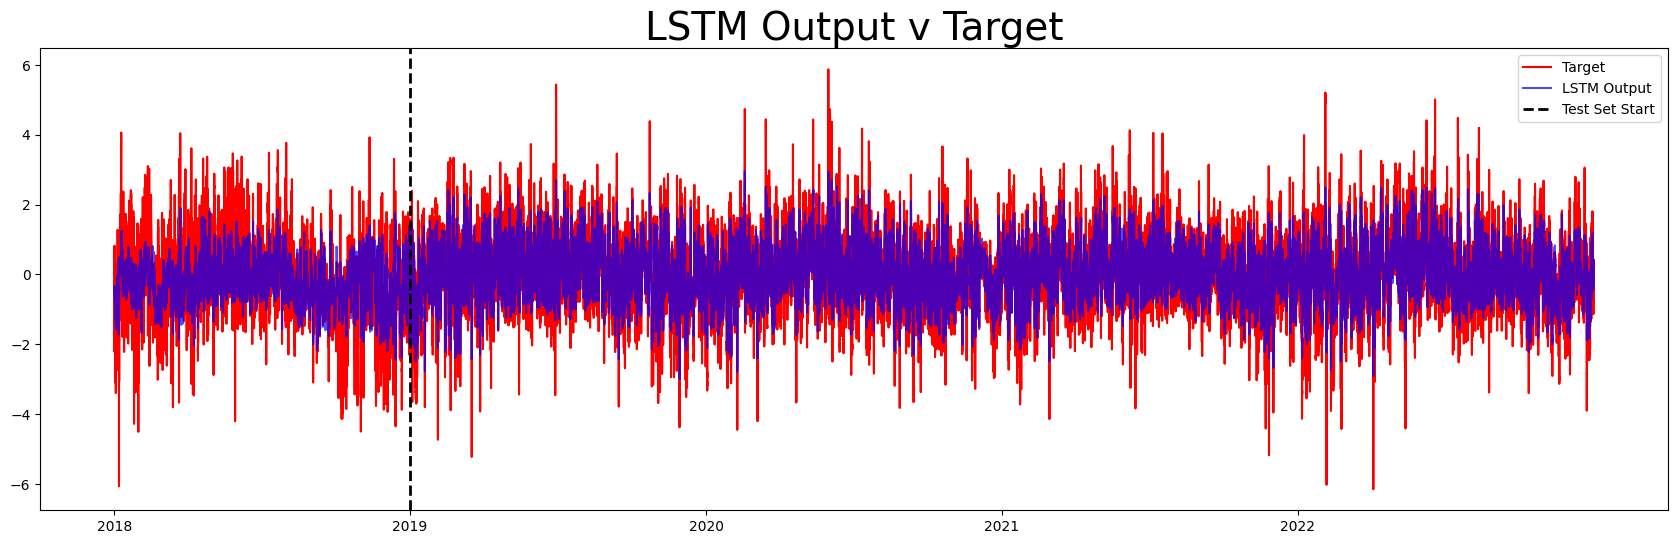

In [53]:
fig, ax = plt.subplots(figsize=(21, 6))
plt.plot(df["target_error"], c="r", label="Target")
plt.plot(df["Model forecast"], c="b", alpha=0.7, label="LSTM Output")
plt.axvline(
    x=(int(0.2 * len(df["target_error"]))),
    c="black",
    linestyle="--",
    linewidth=2.0,
    label="Test Set Start",
)
ax.set_title("LSTM Output v Target", fontsize=28)
ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
ax.set_xticks(np.arange(0, len(df["Model forecast"]), (len(df["Model forecast"]) / 5)))
ax.legend()

/tmp/tmp.Wh09JxUyOf/ipykernel_432037/3762455892.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


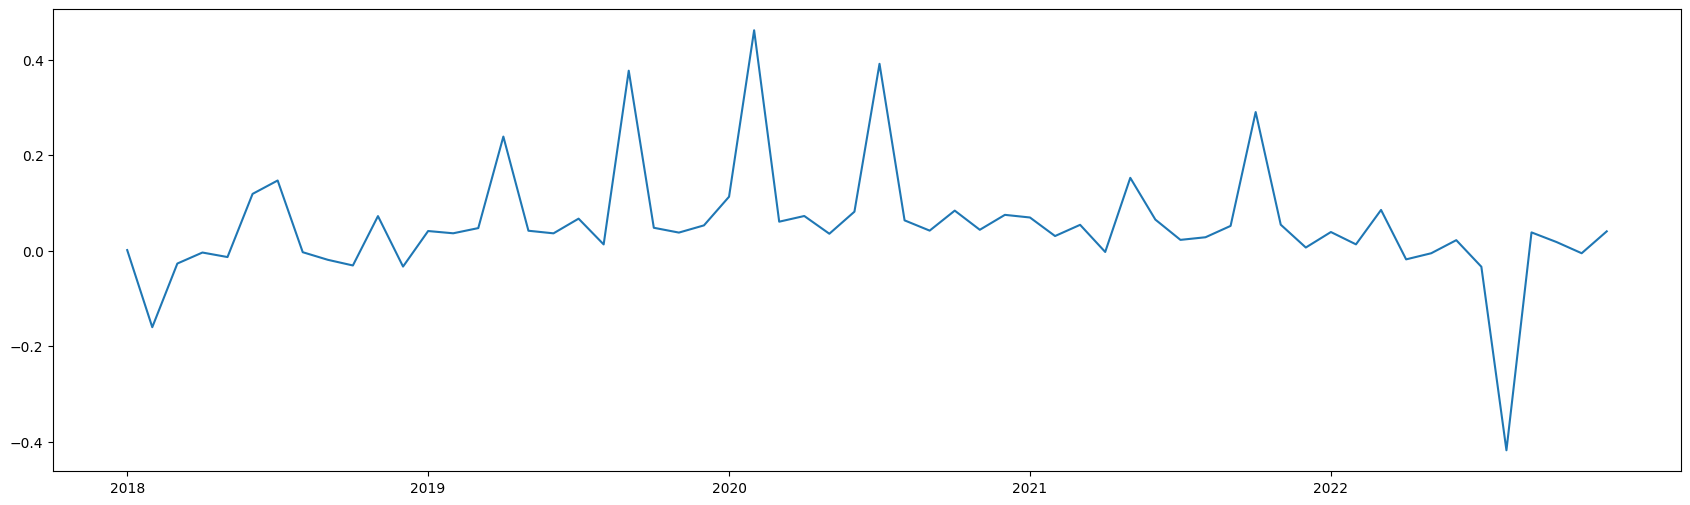

In [23]:
ls = groupby_month(df1, "absolute_error")

In [56]:
nysm_df.head()

,station,time_1H,lat,lon,elev,tair,ta9m,td,relh,srad,pres,mslp,wspd_sonic,wmax_sonic,wdir_sonic,precip_total,snow_depth
54313,OLEA,2018-01-01 01:00:00,42.091412,-78.407433,457.230011,-18.590309,-17.799681,-20.692383,83.486290,0.0,971.673584,978.255127,0.646989,1.288864,43.340260,0.0,0.082778
54314,OLEA,2018-01-01 02:00:00,42.091412,-78.407433,457.230011,-18.669260,-17.254000,-20.511139,85.378731,0.0,971.694824,978.295288,0.771939,1.140073,324.755615,0.0,0.071463
54315,OLEA,2018-01-01 03:00:00,42.091412,-78.407433,457.230011,-19.609180,-18.856810,-21.497772,84.917847,0.0,971.897888,978.725403,0.376827,2.785437,57.137348,0.0,0.079484
54316,OLEA,2018-01-01 04:00:00,42.091412,-78.407433,457.230011,-20.265650,-19.453270,-22.330078,83.534843,0.0,972.117188,979.105408,0.492475,1.581539,65.653053,0.0,0.079795
54317,OLEA,2018-01-01 05:00:00,42.091412,-78.407433,457.230011,-22.711121,-21.218161,-24.819733,82.869072,0.0,972.333191,979.917908,1.775143,2.246752,77.400307,0.0,0.082412


/tmp/tmp.8kK3h4zhjR/ipykernel_2820675/2976645979.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


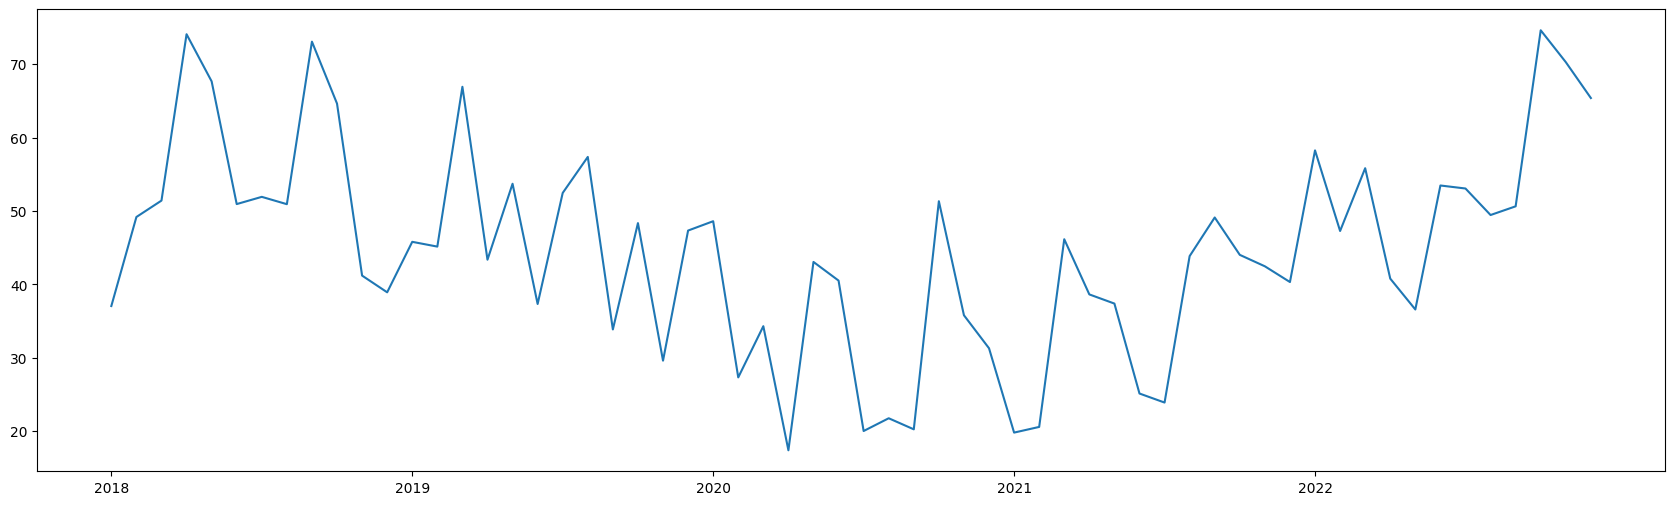

In [57]:
tcc_means = groupby_month_hrrr(hrrr_df, "tcc")

5303910


/tmp/tmp.8kK3h4zhjR/ipykernel_2820675/2066573164.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


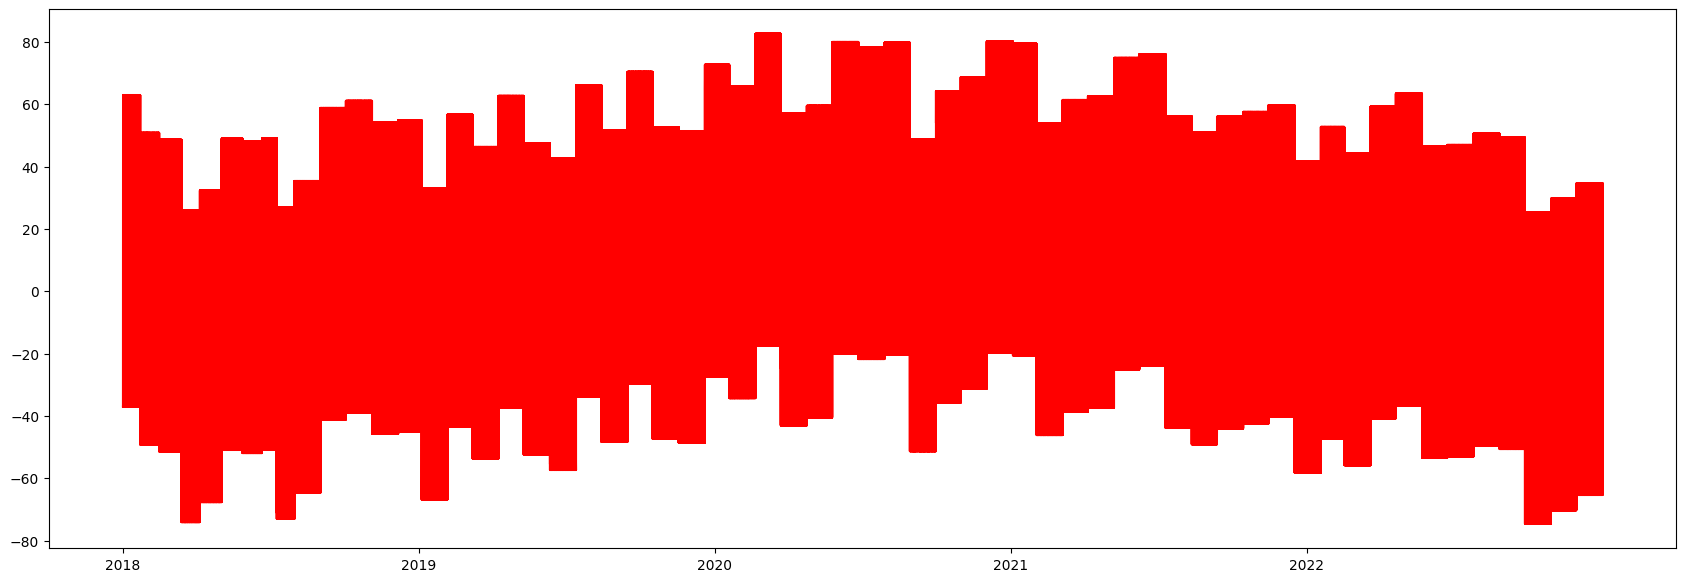

In [58]:
anoms_detection_hrrr(hrrr_df, tcc_means, "tcc")

In [59]:
t2m_means = groupby_month(nysm_df, "tair")

AttributeError: 'DataFrame' object has no attribute 'valid_time'

In [ ]:
anoms = anoms_detection(nysm_df, t2m_means, "tair")

In [ ]:
td_means = groupby_month(nysm_df, "td")

In [ ]:
anoms_td = anoms_detection(nysm_df, td_means, "td")

In [ ]:
relh_means = groupby_month(nysm_df, "relh")

In [ ]:
anoms_detection(nysm_df, relh_means, "relh")

In [ ]:
srad_means = groupby_month(nysm_df, "srad")

In [ ]:
anoms_detection(nysm_df, srad_means, "srad")

In [ ]:
pres_means = groupby_month(nysm_df, "pres")

In [ ]:
anoms_detection(nysm_df, pres_means, "pres")

In [ ]:
mslp_means = groupby_month(nysm_df, "mslp")

In [ ]:
anoms_detection(nysm_df, mslp_means, "mslp")

In [ ]:
wspd_means = groupby_month(nysm_df, "wspd_sonic")

In [ ]:
anoms_detection(nysm_df, wspd_means, "wspd_sonic")

In [ ]:
precip_means = groupby_month(nysm_df, "precip_total")

In [ ]:
anoms_detection(nysm_df, precip_means, "precip_total")

In [ ]:
snow_means = groupby_month(nysm_df, "snow_depth")

In [ ]:
anoms_detection(nysm_df, snow_means, "snow_depth")

In [ ]:
# now we can estimate the IMFs for the signal
x = nysm_df["tair"]
imf = emd.sift.sift(x)
print(imf.shape)

and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [ ]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, "hilbert")

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [ ]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, "log")
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [ ]:
# # visualize
# fig = plt.figure(figsize=(25, 3))
# plt.plot(nysm_df["tair"])

In [ ]:
# df.iloc[:, 9:11]

Plot the IMFs

In [ ]:
emd.plotting.plot_imfs(imf)

In [ ]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)

# ensemble sifting 

In [ ]:
x = nysm_df["wspd_sonic"]
imf_opts = {"sd_thresh": 0.05}

In [ ]:
imf = emd.sift.ensemble_sift(
    x, nensembles=42, nprocesses=12, ensemble_noise=1, imf_opts=imf_opts
)
emd.plotting.plot_imfs(imf)

In [ ]:
imf.shape

and now the Hilbert-Huang transform of this decomposition

In [ ]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate - 0.5)

In [ ]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)